# Классификаторы на основе деревьев принятия решений

### Пример дерева принятия решений 

<img src="img/0014-009-.png">

### Пример построения дерева принятия решения по данным

<img src="img/KYSy4.png">
<img src="img/IkBzK.png"> 

# Определение дерева 
Формально, дерево решений - это *связный ациклический граф*. 

В нем можно выделить 3 типа вершин:
1. **Корневая вершина** (root node) -  откуда все начинается
2. **Внутренние вершины** (intermediate/internal nodes) - промежуточные этапе принятия решения, содержат переходы в другие вершины
3. **Листья** (leafs) - самые глубокие вершины дерева, в которых содержится "ответ". Не содержат переходов в другие верины, являются "тупиками".

<center><img src='img/tree-structure.png' style="width: 50%"><center/>
    
Во внутренней или коневой вершине признак проверяется на некий логический критерий, по результатам которого мы движемся все глубже. 

В листовой вершине содержится целевая информация.

*Решающее дерево реализует кусочно-постоянную функцию*

## Как определяются лучшие разбиения (best splits)?
### Меры неопределенности (impurity measures)

Пусть $p_k$ - это доля класса $C_k$ в узле дерева $S$.

1. Missclassification error  
$$I(S) = 1 - \max\limits_k p_k $$
2. Gini index 
$$I(S) = 1 - \sum\limits_k (p_k)^2 = \sum\limits_{k'\neq k} p_{k'} p_k$$
3. Entropy 
$$I(S) = -\sum\limits_k p_k \log(p_k)$$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')                       
plt.rcParams['figure.figsize'] = (18,12)      

/tmp/ipykernel_152245/102862725.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/edward/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Спасибо Михаилу Трофимову за пример и демонстрашку.

p = np.linspace(0.001, 0.999, 100)  # создать 100 чисел от 0.001 до 0.999
print(p.shape)
p = np.c_[p, 1-p]                   # конкатинирует 2 массива (как функция zip)
                                    # в данном случае мы вектор превратим матрицу высотой 2
print(p.shape)
p[:5]

(100,)
(100, 2)


array([[0.001     , 0.999     ],
       [0.01108081, 0.98891919],
       [0.02116162, 0.97883838],
       [0.03124242, 0.96875758],
       [0.04132323, 0.95867677]])

In [3]:
missclass = 1 - np.max(p, axis=1)
gini = 1 - np.sum(p ** 2, axis=1)
entropy = -1 * np.nansum((p*np.log2(p)), axis=1)    # суммирует, но в случае NaN конвертирует их в 0

print(missclass.shape)
print(missclass[:10])

(100,)
[0.001      0.01108081 0.02116162 0.03124242 0.04132323 0.05140404
 0.06148485 0.07156566 0.08164646 0.09172727]


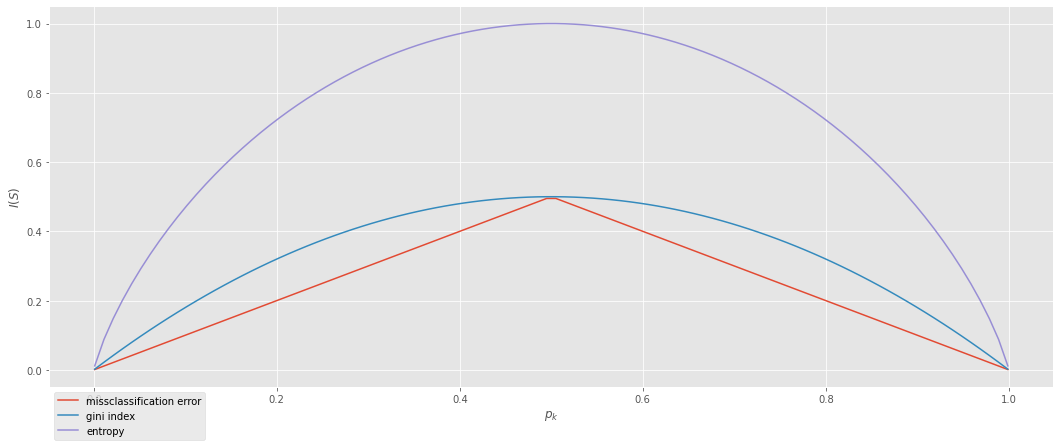

In [4]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(7)

plt.plot(p[:,0], missclass, label = 'missclassification error')
plt.plot(p[:,0], gini, label = 'gini index')
plt.plot(p[:,0], entropy, label = 'entropy')

plt.xlabel('$p_k$')
plt.ylabel('$I(S)$')
plt.legend(loc=2, bbox_to_anchor=(0.,0.))

### Расстояние Кулльбака-Лейблера

Расстояние (дивергенция, корреляция) Кулльбака-Лейблера показывает меру сходства двух распределений.
$$ d_{KL}(P\parallel Q)=\sum\limits_{i=1}^np_i*log(\frac{p_i}{q_i}) $$

<img src="img/KL-Gauss-Example.png"> 

Может использоваться наравне с корреляцией и ранговой корреляцией, хотя в анализе данных зачастую показывает гораздо лучшие результаты в качестве меры сходства.

### Алгоритмы построения деревьев
 
** ID 3 **
* Только категориальные признаки
* Количество потомков = количеству значений признака
* Строится до максимальной глубины

** С 4.5 **
* Поддержка вещественных признаков
* Категриальные как в ID3
* При пропуске значения переход по всем потомкам
* Удаляет избыточные ветвления

** СART **
* Специальная процедура усечения дерева после построения (post prunning)

Прекрасная визуализация алгоритма обучения и принятия решений находится [здесь](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/).

### Преимущества и недостатки

**Преимущества:**
* простота построения;
* интерпретируемость (при небольшой глубине);
* требуются минимальная предобработка признаков;
* встроенный отбор признаков;
* произвольное количество классов.

**Недостатки:**
* границы строяется только параллельно или перпендикулярно осям;
* при изменении набора данных надо полностью перестраивать и результат может получится совершенно иным;
* жадность построения.

In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

from sklearn.tree import export_graphviz
import subprocess

In [6]:
# Спасибо Андрею Шестакову за пример и демонстрашку.

def demo_dec_tree(depth=1):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))

    np.random.seed(0)

    C = np.array([[0., -0.7], [1.5, 0.7]])
    gauss1 = np.dot(np.random.randn(200, 2) + np.array([4, 2]), C)
    gauss2 = np.dot(np.random.randn(300, 2), C)

    X = np.vstack([gauss1, gauss2])
    y = np.r_[np.ones(200), np.zeros(300)]

    ax[1].scatter(X[:,0], X[:, 1], c=y)
    ax[1].set_xlabel('$x_1$')
    ax[1].set_ylabel('$x_2$')

    # Dec Tree Stuff
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=123)
    tree.fit(X,y)

    x_range = np.linspace(X.min(), X.max(), 100)
    xx1, xx2 = np.meshgrid(x_range, x_range)

    Y = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Y = Y.reshape(xx1.shape)

    ax[1].contourf(xx1, xx2, Y, alpha=0.3)
    ax[1].scatter(X[:,0], X[:,1],c=y)
    
#     dot_data = StringIO()  
#     tree.export_graphviz(tree, out_file=dot_data,  
#                      filled=True, rounded=True,  
#                      special_characters=True)  
#     graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#     ax[0].imshow(graph[0].create_png())


    with open('tree.dot', 'w') as fout:
        export_graphviz(tree, out_file=fout, feature_names=['x1', 'x2'], class_names=['0', '1'])
    command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
    subprocess.check_call(command)
    ax[0].imshow(plt.imread('tree.png'))
    ax[0].axis("off")
    
    plt.show()

In [7]:
try:
    fig = interact(demo_dec_tree, depth=IntSlider(min=1, max=10, value=1))
except:
    print('Что-то не так. Посмотрите на доску')

interactive(children=(IntSlider(value=1, description='depth', max=10, min=1), Output()), _dom_classes=('widget…

Посмотрим как работают деревья принятия решений на наборе данных "Титаника".

In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
import random

In [16]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

In [17]:
titanic = pd.read_csv('data/00_titanic_train.csv')
titanic2 = titanic[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()

embenc = LabelEncoder()
titanic2.Embarked = titanic2.Embarked.fillna('S')
embenc.fit(titanic2.Embarked)
titanic2.Embarked = embenc.transform(titanic2.Embarked)

sexenc = LabelEncoder()
sexenc.fit(titanic2.Sex)
titanic2.Sex = sexenc.transform(titanic2.Sex)

titanic2.Age = titanic2.Age.map(lambda x: 
                random.uniform(titanic2.Age.mean() - titanic2.Age.std(), titanic2.Age.mean() + titanic2.Age.std()) \
                if x != x else x)



In [18]:
titanic2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


In [19]:
X_train, X_test, y_train, y_test = train_test_split(titanic2.loc[:, 'Pclass' : 'Embarked'], 
                                                    titanic2['Survived'], test_size=0.2)

In [20]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
489,3,1,9.000000,1,1,15.9000,2
857,1,1,51.000000,0,0,26.5500,2
768,3,1,28.078116,1,0,24.1500,1
311,1,0,18.000000,2,2,262.3750,0
9,2,0,14.000000,1,0,30.0708,0
...,...,...,...,...,...,...,...
382,3,1,32.000000,0,0,7.9250,2
755,2,1,0.670000,1,1,14.5000,2
31,1,0,43.353045,1,0,146.5208,0
166,1,0,33.710214,0,1,55.0000,2


In [21]:
tree = DecisionTreeClassifier(criterion='entropy', random_state=300)

In [22]:
tree.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', random_state=300)

In [23]:
y_hat=tree.predict(X_test)

In [24]:
confusion_matrix(y_test, y_hat)

array([[93, 22],
       [19, 45]])

In [25]:
precision_recall_fscore_support(y_test, y_hat)

(array([0.83035714, 0.67164179]),
 array([0.80869565, 0.703125  ]),
 array([0.81938326, 0.6870229 ]),
 array([115,  64]))

Немного поиграем с параметрами алгоритма принятия решений.

In [ ]:
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown

In [ ]:
def decideTreeDemo(criterion, max_depth, min_samples_leaf, random_state):
    tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=random_state)
    tree.fit(X_train, y_train)
    y_hat=tree.predict(X_test)
    print(precision_recall_fscore_support(y_test, y_hat))

In [ ]:
_ = interact(decideTreeDemo, 
             criterion=Dropdown(options=["gini", "entropy"], value="entropy"),
             max_depth=IntSlider(min=1, max=10, value=3),
             min_samples_leaf=IntSlider(min=1, max=10, value=1),
             random_state=IntSlider(min=100, max=1000, value=300, step=10),
)

interactive(children=(Dropdown(description='criterion', index=1, options=('gini', 'entropy'), value='entropy')…

---

## Случайный лес (Random Forest)

Данные могут быть зашумлены, то есть вектора и классы точек могут быть размечены с ошибками. Постараемся исправить ситуацию при помощи двух нехитрых приемов.

Пусть обучающая выборка состоит из N образцов, размерность пространства признаков равна M, и задан параметр m (в задачах классификации обычно $m\approx \sqrt {M})$ как неполное количество признаков для обучения.

Наиболее распространённый способ построения деревьев комитета следующий.

* Сгенерируем случайную подвыборку с повторениями размером N из обучающей выборки. 
* Построим решающее дерево, классифицирующее образцы данной подвыборки, причём в ходе создания очередного узла дерева будем выбирать набор признаков, на основе которых производится разбиение (не из всех M признаков, а лишь из m случайно выбранных). 
* Дерево строится до полного исчерпания подвыборки и не подвергается процедуре прунинга.

Классификация объектов проводится путём голосования: каждое дерево комитета относит классифицируемый объект к одному из классов, и побеждает класс, за который проголосовало наибольшее число деревьев.

Оптимальное число деревьев подбирается таким образом, чтобы минимизировать ошибку классификатора на тестовой выборке. 

In [29]:
forest=RandomForestClassifier()#criterion='entropy')
forest.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
y_hat2=forest.predict(X_test)

In [31]:
confusion_matrix(y_test, y_hat2)

array([[102,  13],
       [ 16,  48]])

In [32]:
precision_recall_fscore_support(y_test, y_hat2)

(array([0.86440678, 0.78688525]),
 array([0.88695652, 0.75      ]),
 array([0.87553648, 0.768     ]),
 array([115,  64]))